In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from pathlib import Path
import os

DATA_PATH = R"C:\Users\chiar\OneDrive - epfl.ch\ADA\Project\Dataset"
DATA_PATH = Path(os.path.expandvars(DATA_PATH))

#### Data load and separation in "keep_fame" and "lose_fame" populations

In [76]:
# channels_df separated in "keep_fame" and "lose_fame" after matching
keep_fame = pd.read_csv(DATA_PATH / "keep_fame_after_matching.tsv.gz", compression='gzip', sep = '\t')
lose_fame = pd.read_csv(DATA_PATH / "lose_fame_after_matching.tsv.gz", compression='gzip', sep = '\t')

In [77]:
keep_fame.shape

(75, 14)

In [78]:
lose_fame.shape

(75, 14)

In [79]:
keep_fame.columns

Index(['category_cc', 'join_date', 'channel', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights', 'growth_steepness',
       'growth', 'variability', 'growth_rate', 'keep_fame',
       'propensity_score'],
      dtype='object')

In [80]:
# timeseries_df loading and separation in "keep_fame" and "lose_fame" after matching
timeseries_df = pd.read_csv(DATA_PATH / "timeseries_df_filtered.tsv.gz", compression='gzip', sep = '\t', parse_dates=['datetime', 'max_growth_date'])
keep_fame_ts = timeseries_df[timeseries_df['channel'].isin(keep_fame['channel'])]
lose_fame_ts = timeseries_df[timeseries_df['channel'].isin(lose_fame['channel'])]

In [81]:
# metavideos df loading and separation between lose and keep fame
meta_video_filt_original = pd.read_csv(DATA_PATH / "videos_metadata_filtered_population.tsv.gz", sep='\t', compression='gzip')
keep_fame_metavideos = meta_video_filt_original[meta_video_filt_original['channel_id'].isin(keep_fame['channel'])]
lose_fame_metavideos = meta_video_filt_original[meta_video_filt_original['channel_id'].isin(lose_fame['channel'])]

In [82]:
# metavideos dfs with max growth date
keep_fame_metavideos = keep_fame_metavideos.merge(keep_fame_ts.groupby('channel')['max_growth_date'].max(), left_on='channel_id', right_on='channel')
lose_fame_metavideos = lose_fame_metavideos.merge(lose_fame_ts.groupby('channel')['max_growth_date'].max(), left_on='channel_id', right_on='channel')

In [83]:
keep_fame_metavideos.groupby('channel_id').count().shape

(75, 13)

#### Dataframe separation between before and after growth date

<font color = 'green'> **TO DO**

In [84]:
# keep and lose metavideos dfs divided before and after max growth date
keep_metavideos_after_sudden_growth = keep_fame_metavideos[keep_fame_metavideos["upload_date"] > keep_fame_metavideos["max_growth_date"]].copy()
lose_metavideos_after_sudden_growth = lose_fame_metavideos[lose_fame_metavideos["upload_date"] > lose_fame_metavideos["max_growth_date"]].copy()
keep_metavideos_before_sudden_growth = keep_fame_metavideos[keep_fame_metavideos["upload_date"] <= keep_fame_metavideos["max_growth_date"]].copy()
lose_metavideos_before_sudden_growth = lose_fame_metavideos[lose_fame_metavideos["upload_date"] <= lose_fame_metavideos["max_growth_date"]].copy()


In [85]:
# filter video data of "keep" channels that have videos both before sudden growth and after sudden growth
channels_k_b = keep_metavideos_before_sudden_growth["channel_id"].unique()
channels_k_a = keep_metavideos_after_sudden_growth["channel_id"].unique()
index_keep = set.intersection(set(channels_k_b), set(channels_k_a))

print(f"Number of keep fame channels selected: {index_keep.__len__()}")

keep_metavideos_before_sudden_growth = keep_metavideos_before_sudden_growth[keep_metavideos_before_sudden_growth["channel_id"].isin(index_keep)]
keep_metavideos_after_sudden_growth = keep_metavideos_after_sudden_growth[keep_metavideos_after_sudden_growth["channel_id"].isin(index_keep)]


Number of keep fame channels selected: 66


In [86]:
# filter video data of "lose" channels that have videos both before sudden growth and after sudden growth
channels_l_b = lose_metavideos_before_sudden_growth["channel_id"].unique()
channels_l_a = lose_metavideos_after_sudden_growth["channel_id"].unique()
index_lose = set.intersection(set(channels_l_b), set(channels_l_a))

print(f"Number of lose fame channels selected: {index_lose.__len__()}")

lose_metavideos_before_sudden_growth = lose_metavideos_before_sudden_growth[lose_metavideos_before_sudden_growth["channel_id"].isin(index_lose)]
lose_metavideos_after_sudden_growth = lose_metavideos_after_sudden_growth[lose_metavideos_after_sudden_growth["channel_id"].isin(index_lose)]

Number of lose fame channels selected: 63


In [87]:
# filter timeseries data of "keep" and "lose" channels that have videos both before sudden growth and after sudden growth
keep_fame_ts = keep_fame_ts[keep_fame_ts["channel"].isin(index_keep)]
lose_fame_ts = lose_fame_ts[lose_fame_ts["channel"].isin(index_lose)]


### Analysis

<font color = 'green'> **TO DO**

##### Frequency of publication

In [88]:
# compute number of videos posted by each channel before and after sudden growth
keep_num_metavideos_per_channel_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").count()["duration"]
keep_num_metavideos_per_channel_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").count()["duration"]
lose_num_metavideos_per_channel_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").count()["duration"]
lose_num_metavideos_per_channel_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").count()["duration"]

<span style="color:red"> é normale sta cosa?

In [89]:
(keep_fame_ts.groupby("channel")["datetime"].max() - keep_fame_ts.groupby("channel")['max_growth_date'].max()).unique

<bound method Series.unique of channel
UC-tLyAaPbRZiYrOJxAGB7dQ   98 days 00:00:00
UC1L-krRCB6-duxpU6lKX0pQ   98 days 00:00:00
UC2NpT7HjtDpNlwsRSXNwDNQ   98 days 01:00:00
UC2l6OWk60KMxYBheRYEynIQ   98 days 00:00:00
UC35aJQFGtk6gzPvabBSJiIA   97 days 23:00:00
                                 ...       
UCskSW39nbaWKSdtdaPrY5IA   98 days 00:00:00
UCtTVd0bpJ-dsLb3d1ukLgYg   98 days 01:00:00
UCtpy51Y9Nj0375SC9HpE62Q   98 days 00:00:00
UCynqx69mM7IogcYUQI3-Z7g   98 days 00:00:00
UCzVnXCLWqY5dtOBn9UZoFTw   98 days 01:00:00
Length: 66, dtype: timedelta64[ns]>

In [90]:
# compute time of observation of each channel before and after sudden growth
keep_videos_time_after_sudden_growth = (keep_fame_ts.groupby("channel")["datetime"].max() - keep_fame_ts.groupby("channel")["max_growth_date"].mean()).dt.days
lose_videos_time_after_sudden_growth = (lose_fame_ts.groupby("channel")["datetime"].max() - lose_fame_ts.groupby("channel")["max_growth_date"].mean()).dt.days
keep_videos_time_before_sudden_growth = (keep_fame_ts.groupby("channel")["max_growth_date"].mean() - keep_fame_ts.groupby("channel")["datetime"].min()).dt.days
lose_videos_time_before_sudden_growth = (lose_fame_ts.groupby("channel")["max_growth_date"].mean() - lose_fame_ts.groupby("channel")["datetime"].min()).dt.days

In [91]:
# compute frequency of publication of each channel before and after sudden growth
freq_publication_keep_after_sudden_growth = keep_num_metavideos_per_channel_after_sudden_growth / keep_videos_time_after_sudden_growth
freq_publication_lose_after_sudden_growth = lose_num_metavideos_per_channel_after_sudden_growth / lose_videos_time_after_sudden_growth
freq_publication_keep_before_sudden_growth = keep_num_metavideos_per_channel_before_sudden_growth / keep_videos_time_before_sudden_growth
freq_publication_lose_before_sudden_growth = lose_num_metavideos_per_channel_before_sudden_growth / lose_videos_time_before_sudden_growth

In [92]:
# paired t-test for frequency of publication before and after sudden growth of "keep" channels
scs.ttest_rel(freq_publication_keep_after_sudden_growth, freq_publication_keep_before_sudden_growth)

Ttest_relResult(statistic=-2.298424124274345, pvalue=0.02476302468189269)

In [93]:
# paired t-test for frequency of publication before and after sudden growth of "lose" channels
scs.ttest_rel(freq_publication_lose_after_sudden_growth, freq_publication_lose_before_sudden_growth)

Ttest_relResult(statistic=0.17770022373913588, pvalue=0.8595377151165207)

<font color = 'green'> **TO DO** 
Visualization for the distribution 

##### Length of videos

In [94]:
length_keep_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").mean()["duration"]
length_lose_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").mean()["duration"]
length_keep_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").mean()["duration"]
length_lose_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").mean()["duration"]

In [95]:
# paired t-test for length of videos before and after sudden growth of "keep" channels
scs.ttest_rel(length_keep_after_sudden_growth, length_keep_before_sudden_growth)

Ttest_relResult(statistic=1.5814178588363257, pvalue=0.11863672677725806)

In [96]:
# paired t-test for length of videos before and after sudden growth of "lose" channels
scs.ttest_rel(length_lose_after_sudden_growth, length_lose_before_sudden_growth)

Ttest_relResult(statistic=1.227271706566956, pvalue=0.2243601712627319)

<font color = 'green'> **TO DO** Visualization?

#### Number of tags

In [97]:
numtags_lose_metavideo_after_sudden_growth = lose_metavideos_after_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_keep_metavideo_after_sudden_growth = keep_metavideos_after_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_lose_metavideo_before_sudden_growth = lose_metavideos_before_sudden_growth.groupby("channel_id").mean()["num_tags"]
numtags_keep_metavideo_before_sudden_growth = keep_metavideos_before_sudden_growth.groupby("channel_id").mean()["num_tags"]

In [98]:
scs.ttest_rel(numtags_lose_metavideo_after_sudden_growth, numtags_lose_metavideo_before_sudden_growth)

Ttest_relResult(statistic=1.5857773166511753, pvalue=0.1178774899327631)

In [99]:
scs.ttest_rel(numtags_keep_metavideo_after_sudden_growth, numtags_keep_metavideo_before_sudden_growth)

Ttest_relResult(statistic=-0.07999723879658009, pvalue=0.9364852436052005)

<font color = 'green'> **TO DO** Visualization AND description!!

#### Distribution of categories over the videos

In [100]:
# checked that there is a video without category, so we remove it
meta_video_filt_original.drop(meta_video_filt_original[meta_video_filt_original.categories.isna()].index, axis=0, inplace=True)

In [101]:
# save all categories to plot the distribution later
categories = meta_video_filt_original.categories.unique()
categories = ["categories_" + s for s in categories]

In [102]:
# get dummies of categories in metavideos dataframes
keep_metavideos_before_sudden_growth_dummies = pd.get_dummies(keep_metavideos_before_sudden_growth[['channel_id', 'crawl_date','categories']], columns=['categories'], dtype=int)
keep_metavideos_after_sudden_growth_dummies = pd.get_dummies(keep_metavideos_after_sudden_growth[['channel_id','crawl_date','categories']], columns=['categories'], dtype=int)
lose_metavideos_before_sudden_growth_dummies = pd.get_dummies(lose_metavideos_before_sudden_growth[['channel_id','crawl_date','categories']], columns=['categories'], dtype=int)
lose_metavideos_after_sudden_growth_dummies = pd.get_dummies(lose_metavideos_after_sudden_growth[['channel_id','crawl_date','categories']], columns=['categories'], dtype=int)

In [103]:
# fill missing categories with 0 to have the same number of categories in each dataframe
keep_metavideos_before_sudden_growth_dummies = keep_metavideos_before_sudden_growth_dummies.reindex(\
    columns = keep_metavideos_before_sudden_growth_dummies.columns.tolist() + \
    [category for category in categories if category not in keep_metavideos_before_sudden_growth_dummies.columns], \
    fill_value=0)

keep_metavideos_after_sudden_growth_dummies = keep_metavideos_after_sudden_growth_dummies.reindex(\
    columns = keep_metavideos_after_sudden_growth_dummies.columns.tolist() + \
    [category for category in categories if category not in keep_metavideos_after_sudden_growth_dummies.columns], \
    fill_value=0)

lose_metavideos_before_sudden_growth_dummies = lose_metavideos_before_sudden_growth_dummies.reindex(\
    columns = lose_metavideos_before_sudden_growth_dummies.columns.tolist() + \
    [category for category in categories if category not in lose_metavideos_before_sudden_growth_dummies.columns], \
    fill_value=0)

lose_metavideos_after_sudden_growth_dummies = lose_metavideos_after_sudden_growth_dummies.reindex(\
    columns = lose_metavideos_after_sudden_growth_dummies.columns.tolist() + \
    [category for category in categories if category not in lose_metavideos_after_sudden_growth_dummies.columns], \
    fill_value=0)

# b["category_v"] = b["categories"].str.replace(" & ", "_").str.replace(" ", "_")

In [104]:
# Distribution of videos over categories of lose channels after sudden growth
lose_metavideos_after_sudden_growth_dummies_grouped = lose_metavideos_after_sudden_growth_dummies.groupby("channel_id")
num_videos_l_a = lose_metavideos_after_sudden_growth_dummies_grouped.count()["crawl_date"]
num_videos_per_cat_l_a = lose_metavideos_after_sudden_growth_dummies_grouped.sum()

prop_videos_per_cat_l_a = num_videos_per_cat_l_a.divide(num_videos_l_a, axis = 0)
display(prop_videos_per_cat_l_a.head())
print(prop_videos_per_cat_l_a.shape)
print(f"Check the sum of proportions is equal to 1: min_sum_categories = {prop_videos_per_cat_l_a.sum(axis = 1).min()}.")



,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events,categories_Nonprofits & Activism
channel_id,,,,,,,,,,,,,,,
UC16CPKOrO2vB4X7lJMHc6XA,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
UC1TBvaAmpKfSBpwquEakSMw,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
UC58oMWCDv9UsCjl4TJWReGw,0.0,0.0,0.000000,0.666667,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
UC6JmzBg0e91_OAiPeEnRf0w,0.0,0.0,0.821429,0.035714,0.0,0.0,0.0,0.107143,0.0,0.0,0.0,0.035714,0.0,0.0,0.0
UC6p9fCyILda824C9KgKgGeA,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


(63, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 0.9998483929654336.


In [105]:
# Distribution of videos over categories of lose channels before sudden growth
lose_metavideos_before_sudden_growth_dummies_grouped = lose_metavideos_before_sudden_growth_dummies.groupby("channel_id")
num_videos_l_b = lose_metavideos_before_sudden_growth_dummies_grouped.count()["crawl_date"]
num_videos_per_cat_l_b = lose_metavideos_before_sudden_growth_dummies_grouped.sum()

prop_videos_per_cat_l_b = num_videos_per_cat_l_b.divide(num_videos_l_b, axis = 0)
display(prop_videos_per_cat_l_b.head())
print(prop_videos_per_cat_l_b.shape)
print(f"Check the sum of proportions is equal to 1: min_sum_categories = {prop_videos_per_cat_l_b.sum(axis = 1).min()}.")

,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events,categories_Nonprofits & Activism
channel_id,,,,,,,,,,,,,,,
UC16CPKOrO2vB4X7lJMHc6XA,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
UC1TBvaAmpKfSBpwquEakSMw,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.272727,0.000000,0.727273,0.0,0.0,0.0,0.0,0.0
UC58oMWCDv9UsCjl4TJWReGw,0.0,0.0,0.0,0.142157,0.0,0.0,0.0,0.000000,0.009804,0.848039,0.0,0.0,0.0,0.0,0.0
UC6JmzBg0e91_OAiPeEnRf0w,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.666667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
UC6p9fCyILda824C9KgKgGeA,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


(63, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 0.9999999999999999.


In [106]:
# Distribution of videos over categories of keep channels after sudden growth
keep_metavideos_after_sudden_growth_dummies_grouped = keep_metavideos_after_sudden_growth_dummies.groupby("channel_id")
num_videos_k_a = keep_metavideos_after_sudden_growth_dummies_grouped.count()["crawl_date"]
num_videos_per_cat_k_a = keep_metavideos_after_sudden_growth_dummies_grouped.sum()

prop_videos_per_cat_k_a = num_videos_per_cat_k_a.divide(num_videos_k_a, axis = 0)
display(prop_videos_per_cat_k_a.head())
print(prop_videos_per_cat_k_a.shape)
print(f"Check the sum of proportions is equal to 1: min_sum_categories = {prop_videos_per_cat_k_a.sum(axis = 1).min()}.")

,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events
channel_id,,,,,,,,,,,,,,,
UC-tLyAaPbRZiYrOJxAGB7dQ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC1L-krRCB6-duxpU6lKX0pQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC2NpT7HjtDpNlwsRSXNwDNQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC2l6OWk60KMxYBheRYEynIQ,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC35aJQFGtk6gzPvabBSJiIA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(66, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 0.9999999999999999.


In [107]:
# Distribution of videos over categories of keep channels before sudden growth
keep_metavideos_before_sudden_growth_dummies_grouped = keep_metavideos_before_sudden_growth_dummies.groupby("channel_id")
num_videos_k_b = keep_metavideos_before_sudden_growth_dummies_grouped.count()["crawl_date"]
num_videos_per_cat_k_b = keep_metavideos_before_sudden_growth_dummies_grouped.sum()

prop_videos_per_cat_k_b = num_videos_per_cat_k_b.divide(num_videos_k_b, axis = 0)
display(prop_videos_per_cat_k_b.head())
print(prop_videos_per_cat_k_b.shape)
print(f"Check the sum of proportions is equal to 1: min_sum_categories = {prop_videos_per_cat_k_b.sum(axis = 1).min()}.")

,categories_Autos & Vehicles,categories_Comedy,categories_Education,categories_Entertainment,categories_Film & Animation,categories_Gaming,categories_Howto & Style,categories_Music,categories_News & Politics,categories_Nonprofits & Activism,categories_People & Blogs,categories_Pets & Animals,categories_Science & Technology,categories_Sports,categories_Travel & Events
channel_id,,,,,,,,,,,,,,,
UC-tLyAaPbRZiYrOJxAGB7dQ,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
UC1L-krRCB6-duxpU6lKX0pQ,0.0,0.0,0.0,0.012821,0.000000,0.0,0.0,0.884615,0.0,0.0,0.102564,0.0,0.0,0.0,0.0
UC2NpT7HjtDpNlwsRSXNwDNQ,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
UC2l6OWk60KMxYBheRYEynIQ,0.0,0.0,0.0,0.000000,0.985075,0.0,0.0,0.014925,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
UC35aJQFGtk6gzPvabBSJiIA,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


(66, 15)
Check the sum of proportions is equal to 1: min_sum_categories = 0.9999999999999999.


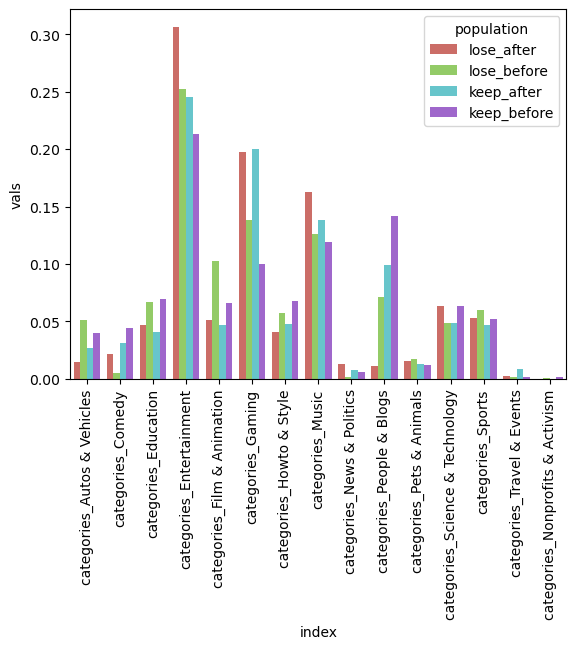

In [108]:
import seaborn as sns
video_distr_for_plotting = pd.concat(\
    [prop_videos_per_cat_l_a.mean(), prop_videos_per_cat_k_a.mean(), prop_videos_per_cat_l_b.mean(), prop_videos_per_cat_k_b.mean()], axis=1)\
    .rename(columns={0:"lose_after", 1:"lose_before", 2:"keep_after", 3:"keep_before"})

video_distr_for_plotting.reset_index(inplace=True)
video_distr_for_plotting = video_distr_for_plotting.melt('index', var_name='population', value_name='vals')

sns.barplot(data=video_distr_for_plotting, x="index", y="vals", hue="population", palette="hls")
plt.xticks(rotation=90);

##### Statistical analysis of the distribution of videos over categories 

In [111]:
keep_fame_metavideos['before_fame'] = np.where(keep_fame_metavideos["upload_date"] > keep_fame_metavideos["max_growth_date"], 0, 1)
lose_fame_metavideos['before_fame'] = np.where(lose_fame_metavideos["upload_date"] > lose_fame_metavideos["max_growth_date"], 0, 1)
display(keep_fame_metavideos.sample(5))
keep_fame_metavideos.groupby("channel_id").count().shape

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_tags,max_growth_date,before_fame
1313,Science & Technology,UCpd0xtuhhWwUug1bk84usiA,2019-11-04 03:41:28.800700,"Geleneksel bir perakendeci, hizmet sektöründe ...",5.0,f9EV5Ga328s,234,58.0,"sosyal ağlar,Online,skills,organik,Büyüme,E-ti...",Online mağazanızı kurun - E-ticaret kullanarak...,2017-09-15 00:00:00,4695.0,34,2018-04-02 01:00:00,1
28860,Howto & Style,UCsgkhimI0MthrMZo-F2zrTQ,2019-11-19 20:34:19.140830,I watched the Democrat debate since a good war...,20.0,8qTk5cIII5U,1002,151.0,"rick gore,gun tactics,deadly force,survivalist...",Democratic Presidential Debate Review 2015 - W...,2015-10-14 00:00:00,2991.0,22,2018-05-07 00:00:00,1
16428,Gaming,UCXQexglLCaJyTImYLmSO9Ng,2019-11-20 23:52:34.422433,Watch one of the forgotten videos (intro for a...,1.0,CR5vVD9_G5g,43,23.0,"esl,tv,es.tv,esl-tv,esl_tv,electronic,sports,l...",Forgotten files: Looking for movies,2010-11-16 00:00:00,1806.0,23,2019-05-27 00:00:00,1
18501,Music,UCK7V1UcYLOBWk6Ur4Wf8wrg,2019-11-01 02:59:31.362457,MSFTSrep MUSIC\n\n• Follow: Jaden Smith\n\n►Tw...,23.0,WdC-7dJK2Bw,228,1164.0,NaN,Jaden Smith - Girl I'm In Love With You,2018-01-04 00:00:00,53001.0,1,2018-11-04 23:00:00,1
12111,Gaming,UCXQexglLCaJyTImYLmSO9Ng,2019-11-20 23:51:13.529018,The ESL Pro League returns for its fifth seaso...,3.0,APiWdUWx9iA,3216,113.0,"ESL,Counter-Strike,North,NaVi,Pro league,ProLe...",CS:GO - Na'Vi vs. North [Cbble] Map 1 - ESL Pr...,2017-03-24 00:00:00,9143.0,20,2019-05-27 00:00:00,1


(75, 14)

In [113]:
contingency_table_lose = {}
results_lose = {}
for channel in lose_fame_metavideos['channel_id'].unique():
    
    if channel in contingency_table_lose:
        continue
    else:
        df_of_channel = lose_fame_metavideos[lose_fame_metavideos["channel_id"] == f"{channel}"]
        
        contingency_table_lose[f"{channel}"] = pd.crosstab(df_of_channel["before_fame"], df_of_channel["categories"])
        chi2, p, dof, expected = scs.chi2_contingency(contingency_table_lose[f"{channel}"])
        results_lose[f"{channel}"] = [chi2, p, dof, expected]

In [114]:
# DUBBIO AMLETICO: categorie considerate TIENI A ZERO
for key in results_lose:
    if results_lose[key][1] < 0.05:
        print(f"{key}: chi-stat {results_lose[key][0]} -- p-value {results_lose[key][1]}")

UCphO96ypf0z0ynM5r5rDF6w: chi-stat 9.04779411764706 -- p-value 0.010846671081649481
UCytLmyg_OJXmNkHEMS0w2Cw: chi-stat 103.90337409506981 -- p-value 1.4506037339594293e-21
UCmHr3gIlwwgdj_kVTcW-yqw: chi-stat 17.529384703852784 -- p-value 0.00015615017524861662
UCj-J4HHrtX3gT9ZEWqAf2Dw: chi-stat 299.6415502796173 -- p-value 1.1894531885294357e-64
UCiIfXQzQUTQtHSgb4ce247g: chi-stat 748.4816717466243 -- p-value 8.581066057461583e-165
UCgvVxB6GKYpyZY1Hh9u-uSQ: chi-stat 24.270289097875303 -- p-value 2.1935687880202468e-05
UCeLh8W_7_Y8xxIlCA3iT8gw: chi-stat 267.63948083837585 -- p-value 7.635283483575694e-59
UCcEWKT3bmBENciUiAKDjIOQ: chi-stat 75.14124293785311 -- p-value 4.8226574387462816e-17
UCaOI6eIy2scNgiaNwxWiaYg: chi-stat 47.30840590947686 -- p-value 6.065156103550415e-12
UCa1yUHQmV6Z0PpAUtfgNd9g: chi-stat 23.595435326908543 -- p-value 0.00025962660572354364
UCWKeZvw4iSZVM2qXKZde58A: chi-stat 144.9367741935484 -- p-value 2.474456805026227e-30
UCTiMHUxl_43kP2X4y4JFgdg: chi-stat 25.560570

In [115]:
contingency_table_keep = {}
results_keep = {}

for channel in keep_fame_metavideos['channel_id'].unique():
    if channel in contingency_table_keep:
        continue
    else:
        df_of_channel = keep_fame_metavideos[keep_fame_metavideos["channel_id"] == f"{channel}"]
        
        contingency_table_keep[f"{channel}"] = pd.crosstab(df_of_channel["before_fame"], df_of_channel["categories"])
        chi2, p, dof, expected = scs.chi2_contingency(contingency_table_keep[f"{channel}"])
        results_keep[f"{channel}"] = [chi2, p, dof, expected]


In [116]:
for key in results_keep:
    if results_keep[key][1] < 0.05:
        print(f"{key}: chi-stat {results_keep[key][0]} -- p-value {results_keep[key][1]}")

UCzVnXCLWqY5dtOBn9UZoFTw: chi-stat 52.67738831145983 -- p-value 3.930907933725064e-13
UCrHUdW8KCyqXX9pBYtSp0Pw: chi-stat 31.25244135567044 -- p-value 8.351235041644888e-06
UCpd0xtuhhWwUug1bk84usiA: chi-stat 28.820784363417147 -- p-value 7.939451451902105e-08
UCpci_E3rz6pTveUgZMF6Jjg: chi-stat 251.2441839431392 -- p-value 2.7734392127288478e-55
UCoe22kmGNpHmYBV220VW3PQ: chi-stat 27.1875 -- p-value 1.2482724531808147e-06
UCkYQmpR28_mtoOtz4zxE-UQ: chi-stat 27.723913043478262 -- p-value 0.0010606121801316638
UCitT48tHffPMf0UfYYizedQ: chi-stat 11.105303444505196 -- p-value 0.003877162442106955
UChv8Af2iQymYKPcT2R9zGgA: chi-stat 40.55720296082976 -- p-value 0.000208756311696821
UCfkLORBXRuCEL4L9Xp5ED-Q: chi-stat 6.5360243055555545 -- p-value 0.010571133658950271
UCekZMO1ElC_qGzNGMRbNV_w: chi-stat 164.68000749451207 -- p-value 1.4489194699487956e-34
UCe0Nogjw-jIe5PC_hHyiN3Q: chi-stat 68.9887387186464 -- p-value 1.0454077864721998e-15
UCWQNxN6-Ur_VJyBR1YRxbeQ: chi-stat 18.643867895143405 -- p-

<font color = 'red'> HOW TO DO THE COMPARISON OF THE DISTRIBUTIONS OF THE DISTRIBUTIONS?

### Analysis within categories
<font color='green'> **TO DO**

In [117]:
categories_to_analyse = ["Entertainment", "Gaming", "Music", "People & Blogs"]


In [130]:
result = {}

for i in categories_to_analyse:
    dict_category = {}

    print(f"Category: {i}")
    
    # filter by category
    L_A_metavideos = lose_metavideos_after_sudden_growth[lose_metavideos_after_sudden_growth["categories"] == i]
    K_A_metavideos = keep_metavideos_after_sudden_growth[keep_metavideos_after_sudden_growth["categories"] == i]
    L_B_metavideos = lose_metavideos_before_sudden_growth[lose_metavideos_before_sudden_growth["categories"] == i]
    K_B_metavideos = keep_metavideos_before_sudden_growth[keep_metavideos_before_sudden_growth["categories"] == i]
    print(f"check shapes: {L_A_metavideos.groupby('channel_id').count().shape} \
        {K_A_metavideos.groupby('channel_id').count().shape} \
        {L_B_metavideos.groupby('channel_id').count().shape} \
        {K_B_metavideos.groupby('channel_id').count().shape}")

    L_ts = lose_fame_ts[lose_fame_ts["channel"].isin(L_A_metavideos["channel_id"])]
    K_ts = keep_fame_ts[keep_fame_ts["channel"].isin(K_A_metavideos["channel_id"])]

    # frequency of publication
    L_A_num_metavideos = L_A_metavideos.groupby("channel_id").count()['duration']
    K_A_num_metavideos = K_A_metavideos.groupby("channel_id").count()['duration']
    L_B_num_metavideos = L_B_metavideos.groupby("channel_id").count()['duration']
    K_B_num_metavideos = K_B_metavideos.groupby("channel_id").count()['duration']
   
    L_A_time = (L_ts.groupby("channel")['datetime'].max() - L_ts.groupby("channel")['max_growth_date'].mean()).dt.days
    K_A_time = (K_ts.groupby("channel")['datetime'].max() - K_ts.groupby("channel")['max_growth_date'].mean()).dt.days
    L_B_time = (L_ts.groupby("channel")['max_growth_date'].mean() - L_ts.groupby("channel")['datetime'].min()).dt.days
    K_B_time = (K_ts.groupby("channel")['max_growth_date'].mean() - K_ts.groupby("channel")['datetime'].min()).dt.days
    
    L_A_freq = L_A_num_metavideos / L_A_time
    K_A_freq = K_A_num_metavideos / K_A_time
    L_B_freq = L_B_num_metavideos / L_B_time
    K_B_freq = K_B_num_metavideos / K_B_time

    dict_category["freq_of_publication"] = {'L_A_freq': L_A_freq, 'K_A_freq': K_A_freq, 'L_B_freq': L_B_freq, 'K_B_freq': K_B_freq}

    # duration of videos
    L_A_duration = L_A_metavideos.groupby("channel_id").mean()['duration']
    K_A_duration = K_A_metavideos.groupby("channel_id").mean()['duration']
    L_B_duration = L_B_metavideos.groupby("channel_id").mean()['duration']
    K_B_duration = K_B_metavideos.groupby("channel_id").mean()['duration']

    dict_category["duration_of_videos"] = {'L_A_duration': L_A_duration, 'K_A_duration': K_A_duration, 'L_B_duration': L_B_duration, 'K_B_duration': K_B_duration}

    # number of tags
    L_A_num_tags = L_A_metavideos.groupby("channel_id").mean()['num_tags']
    K_A_num_tags = K_A_metavideos.groupby("channel_id").mean()['num_tags']
    L_B_num_tags = L_B_metavideos.groupby("channel_id").mean()['num_tags']
    K_B_num_tags = K_B_metavideos.groupby("channel_id").mean()['num_tags']

    dict_category["num_of_tags"] = {'L_A_num_tags': L_A_num_tags, 'K_A_num_tags': K_A_num_tags, 'L_B_num_tags': L_B_num_tags, 'K_B_num_tags': K_B_num_tags}

    result[i] = dict_category



Category: Entertainment
check shapes: (35, 13)         (22, 13)         (31, 13)         (37, 13)
Category: Gaming
check shapes: (19, 13)         (12, 13)         (17, 13)         (15, 13)
Category: Music
check shapes: (19, 13)         (10, 13)         (14, 13)         (18, 13)
Category: People & Blogs
check shapes: (3, 13)         (11, 13)         (22, 13)         (33, 13)


<font color='red'> aiuto devo stringere il numero di categorie?

Statistical tests